<a href="https://colab.research.google.com/github/bmalecki/animal-shelter-kaggle/blob/master/animal_shelter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float64')


In [39]:
data_df = pd.read_csv("drive/My Drive/animal-shelter/train.csv")
data_df

,ID,Animal ID,Name,DateTime,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,95779,A720945,Jeet,02/19/2016 07:11:00 PM,12/03/2015,Adoption,Dog,Intact Male,2 months,Rottweiler Mix,Tricolor
1,97632,A697146,NaN,02/19/2015 09:00:00 AM,06/18/2014,Transfer,Cat,Unknown,8 months,Domestic Shorthair Mix,Black/White
2,117838,A818712,Diamond,06/14/2020 11:34:00 AM,06/13/2019,Return to Owner,Dog,Intact Female,1 year,Siberian Husky,Red/White
3,10803,A673623,Shtinker,03/09/2014 12:13:00 PM,02/27/2011,Return to Owner,Dog,Spayed Female,3 years,Chihuahua Shorthair Mix,White/Brown
4,100331,A742185,NaN,01/18/2017 08:15:00 AM,01/17/2015,Euthanasia,Other,Unknown,2 years,Coyote,Brown
...,...,...,...,...,...,...,...,...,...,...,...
96325,50057,A753764,Princess,07/11/2017 01:19:00 PM,07/10/2015,Return to Owner,Dog,Intact Female,2 years,Pomeranian Mix,White/Brown
96326,98047,A714597,Crazy,02/02/2016 12:58:00 PM,09/25/2015,Adoption,Cat,Spayed Female,4 months,Domestic Shorthair Mix,Blue/White
96327,5192,A696264,Chocolate,02/08/2015 05:26:00 PM,02/01/2013,Euthanasia,Dog,Neutered Male,2 years,Pit Bull Mix,Chocolate/White
96328,77708,A670869,Gregory,01/19/2014 03:01:00 PM,10/31/2013,Transfer,Dog,Neutered Male,2 months,Pit Bull/Labrador Retriever,Black/White


In [40]:
out_columns = data_df['Outcome Type'].unique()
out_columns.sort()
out_columns

array(['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Missing',
       'Relocate', 'Return to Owner', 'Rto-Adopt', 'Transfer'],
      dtype=object)

In [47]:
def mapAge(row):
  s = str(row['Age upon Outcome']).split()
  if pd.isna(row['Age upon Outcome']):
    s = '8 year'

  days = 2920; # 8 year

  if s[1].startswith("year"):
    days = int(s[0]) * 365
  if s[1].startswith("month"):
    days = int(s[0]) * 30
  if s[1].startswith("week"):
    days = int(s[0]) * 7
  if s[1].startswith("day"):
    days = int(s[0])
  
  if days < 0:
    days *= -1

  return days / (30*350) # normalize

def prepare_data(df):
  df['hasName'] = df.apply(lambda row : int(pd.notnull(row['Name'])), axis = 1)
  df['ageInDays'] = df.apply(mapAge, axis = 1)
  df['outcomeMonth'] = pd.DatetimeIndex(df['DateTime']).month

  df['Male'] = df.apply(lambda row : int('Male' in str(row['Sex upon Outcome'])), axis = 1)
  df['Female'] = df.apply(lambda row : int('Female' in str(row['Sex upon Outcome'])), axis = 1)
  df['Spayed'] = df.apply(lambda row : int('Spayed' in str(row['Sex upon Outcome'])), axis = 1)
  df['Neutered'] = df.apply(lambda row : int('Neutered' in str(row['Sex upon Outcome'])), axis = 1)
  df['Intact'] = df.apply(lambda row : int('Intact' in str(row['Sex upon Outcome'])), axis = 1)


  df['Tricolor'] = df.apply(lambda row : int('Tricolor' in str(row['Color'])), axis = 1)
  df['DarkFur'] = df.apply(lambda row : int(('Gray' or 'Black' or 'Brown' or 'Blue') in str(row['Color'])), axis = 1)
  df['MixBreed'] = df.apply(lambda row : int('Mix' in str(row['Breed']) or '/' in str(row['Breed'])), axis = 1)

  df = pd.get_dummies(df, prefix='', prefix_sep='_', columns=['Animal Type'])
  df = pd.get_dummies(df, prefix='month', columns=['outcomeMonth'])

  df = df.drop(['Animal ID', 'Name', 'Age upon Outcome', 'DateTime',
                'Date of Birth', 'Breed', 'Sex upon Outcome', 'Color'],
               axis=1)

  return df

# df = prepare_data(data_df.sample(n=1000))
# df = prepare_data(data_df.copy(deep=True).head(20000))
df = prepare_data(data_df)
df

,ID,Outcome Type,ageInDays,Male,Female,Spayed,Neutered,Intact,Tricolor,DarkFur,MixBreed,hasName,_Bird,_Cat,_Dog,_Livestock,_Other,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,95779,Adoption,0.005714,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,97632,Transfer,0.022857,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,117838,Return to Owner,0.034762,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,10803,Return to Owner,0.104286,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,100331,Euthanasia,0.069524,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96325,50057,Return to Owner,0.069524,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
96326,98047,Adoption,0.011429,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
96327,5192,Euthanasia,0.069524,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
96328,77708,Transfer,0.005714,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [42]:
from sklearn.model_selection import train_test_split

shelter_features = df.columns.to_list()
shelter_features.remove('Outcome Type')

# Separate features and labels
shelter_X, shelter_y = df[shelter_features], df['Outcome Type']


# Split data 70%-30% into training set and test set
x_shelter_train, x_shelter_test, y_shelter_train, y_shelter_test = train_test_split(shelter_X, shelter_y,
                                                                                    test_size=0.30,
                                                                                    random_state=1,
                                                                                    stratify=shelter_y)

train_ids = x_shelter_train.pop('ID')
test_ids = x_shelter_test.pop('ID').values

print ('Training Set: %d, Test Set: %d \n' % (x_shelter_train.size, x_shelter_test.size))


Training Set: 1753206, Test Set: 751374 



In [43]:
from sklearn.linear_model import LogisticRegression


# train a logistic regression model on the training set
model = LogisticRegression(C=0.01, solver='saga', multi_class='auto', max_iter=1000).fit(x_shelter_train, y_shelter_train)
print (model)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn. metrics import classification_report

%matplotlib inline

shelter_prediction = model.predict(x_shelter_test)
print(classification_report(y_shelter_test, shelter_prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.65      0.93      0.77     12722
           Died       0.00      0.00      0.00       270
       Disposal       0.00      0.00      0.00       126
     Euthanasia       0.71      0.53      0.61      1940
        Missing       0.00      0.00      0.00        16
       Relocate       0.00      0.00      0.00         5
Return to Owner       0.49      0.15      0.23      5056
      Rto-Adopt       0.00      0.00      0.00       150
       Transfer       0.68      0.61      0.64      8614

       accuracy                           0.65     28899
      macro avg       0.28      0.25      0.25     28899
   weighted avg       0.62      0.65      0.61     28899



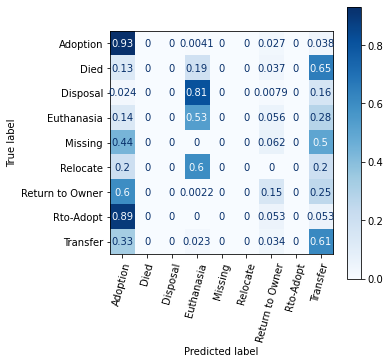

In [45]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

# normalize https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
plot_confusion_matrix(model, x_shelter_test, y_shelter_test,
                                 display_labels=out_columns,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 xticks_rotation=75,
                                 ax=ax)

In [46]:
shelter_prediction_proba = model.predict_proba(x_shelter_test)
shelter_prediction_proba = shelter_prediction_proba.round(2)

out_df = pd.DataFrame(shelter_prediction_proba, columns=out_columns)
out_df.insert(0, 'ID', test_ids)

out_df

,ID,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,5570,0.57,0.00,0.0,0.02,0.0,0.0,0.26,0.01,0.14
1,66505,0.66,0.00,0.0,0.01,0.0,0.0,0.17,0.00,0.14
2,3483,0.45,0.01,0.0,0.05,0.0,0.0,0.14,0.01,0.33
3,81454,0.74,0.01,0.0,0.02,0.0,0.0,0.03,0.00,0.19
4,86902,0.69,0.00,0.0,0.01,0.0,0.0,0.18,0.01,0.12
...,...,...,...,...,...,...,...,...,...,...
28894,21123,0.65,0.00,0.0,0.02,0.0,0.0,0.18,0.00,0.14
28895,111726,0.75,0.01,0.0,0.02,0.0,0.0,0.04,0.01,0.17
28896,42017,0.76,0.01,0.0,0.02,0.0,0.0,0.03,0.00,0.17
28897,102726,0.09,0.01,0.0,0.06,0.0,0.0,0.31,0.01,0.51
